In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
# torch.autograd.set_detect_anomaly(True)

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta_manuscript as lam
import latenta as la
import lacell as lac

import scanpy as sc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
experiment = lam.Experiment("cellcycle")

In [4]:
counts = pd.read_csv(experiment.data_file("counts.csv"), header = None)
var = pd.read_csv(experiment.data_file("var.csv"), index_col = 0)
var.index.name = "gene"
obs = pd.read_csv(experiment.data_file("obs.csv"), index_col = 0)
obs.index.name = "cell"

obs["batch"] = obs["experiment_ix"].astype("category")

counts.index = var.index
counts.columns = obs.index

counts = counts.T
adata = sc.AnnData(counts, obs, var)
dataset = lac.dataset.Dataset(lac.dataset.Transcriptome(adata))

In [5]:
dataset["transcriptome"] = dataset["transcriptome"].select_features(dataset.var.index.isin(lac.scalar.cellcycle.get_cellcycle_genes("mm")["gene"]))
dataset["transcriptome"] = dataset["transcriptome"].select_samples(dataset["transcriptome"].counts.sum(1) > 10)
print(dataset.var.shape[0])
print(dataset.obs.shape[0])

85
1285


In [6]:
sc.pp.normalize_per_cell(dataset.adata)
sc.pp.log1p(dataset.adata)
sc.pp.highly_variable_genes(dataset.adata)
sc.pp.pca(dataset.adata)
sc.pp.neighbors(dataset.adata)
sc.tl.umap(dataset.adata)

... storing 'orig.ident' as categorical
... storing 'barcode' as categorical
... storing 'timepoint' as categorical
... storing 'condition_id' as categorical
... storing 'condition_experiment_id' as categorical
... storing 'Phase' as categorical
... storing 'phase' as categorical
... storing 'biotype' as categorical


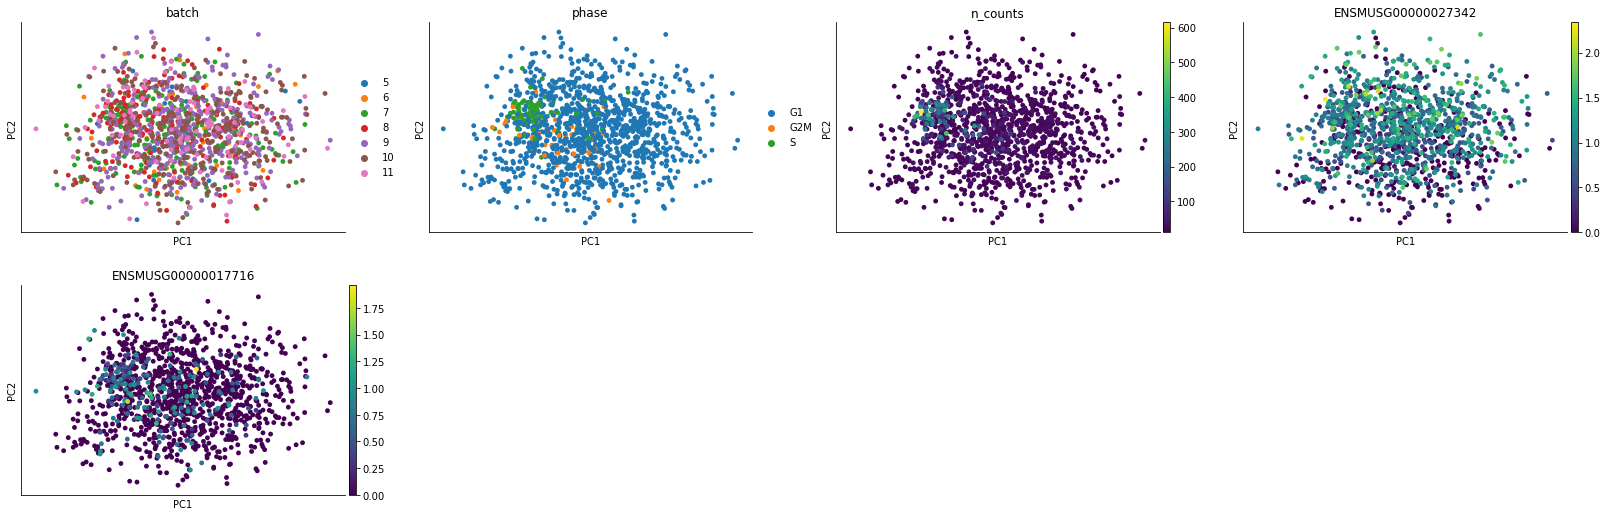

In [7]:
sc.pl.pca(dataset.adata, color = ["batch", "phase", "n_counts"] + dataset.feature_id(["Pcna", "Birc5"]))

In [8]:
dataset_oi = dataset

Our dataset is heavily unbalanced, with many more cells in the G1 phase than the G2, M and S phases. This is problematic because the modelling will try to explain each cell equally, and will thus favour explaining heterogeneity inside the non-cycling population over differences between cycling and cycling cells. We can overcome this by providing weights to observations, in such a way that each cell cycle phase is equally represented in the data:

In [9]:
weights_value = pd.Series((1/dataset_oi.obs["phase"].value_counts())[dataset_oi.obs["phase"]].values, index = dataset_oi.obs.index)
weights_value = weights_value/weights_value.sum() * len(weights_value)
weights = la.Fixed(weights_value)

We provide these weights to the transcriptome together with the transcriptome modality. Note that these weights are optional.

💡 Try not providing the weights to the transcriptome (and later the library size) to see what effect it has on the latent cell cycle

In [10]:
transcriptome = lac.transcriptome.Transcriptome(dataset_oi["transcriptome"], weights = weights)

In [148]:
# la.interpretation.ComponentGraph(transcriptome)

We model the cell cycle as a latent variable that follows a uniform circular distribution, i.e. equal probability everywhere between $0$ and $2\pi$. This variable needs to be modelled for each cell. This cell cycle variable will create a variational distribution.

In [11]:
cellcycle = la.Latent(
    la.distributions.CircularUniform(),
    transcriptome[:1],
    label = "cellcycle"
)

We have two options to model the cell cycle position for each cell: either

In [12]:
transcriptome_amortization = la.Fixed(dataset["transcriptome"].counts.astype(np.float), label = "observed")
nn = torch.nn.Sequential(
    torch.nn.Linear(transcriptome_amortization.shape[1], 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 20),
    torch.nn.ReLU()
)
nn = la.nn.NN(transcriptome_amortization, nn, output = transcriptome_amortization.subset(transcriptome_amortization[0]).expand_right(la.Dimeries(range(20), name = "virtual"), color = "grey")), label = "■")

loc = cellcycle.variational.x.loc
scale = cellcycle.variational.x.scale.x

nn_loc = la.nn.Linear(nn, loc.broadcast(loc[0]))
nn_scale = la.nn.Linear(nn, scale.broadcast(scale[0]))

cellcycle.variational.x.loc = nn_loc
cellcycle.variational.x.scale.x = nn_scale

In [13]:
cellcycle_effect = la.links.scalar.Spline(
    cellcycle,
    output = transcriptome.dist.mu.expression.foldchange, 
    distance = la.links.scalar.spline.circular
)
transcriptome.dist.mu.expression.foldchange.cellcycle_effect = cellcycle_effect

Most transcriptome analyses see the library size (i.e. number of UMIs or transcripts) as a nuissance variable, that needs to modelled or regressed in some way. This is also the case by default for the `Transcriptome` module: by default the library size will be modelled as a fixed variable equal to the empirical library size.

However the library size is often related to relevant biological processes, such as cell size, cell proliferation and differentiation. Obviously, if we only focus on S-phase and G2M-phase genes, the library size will be cell-cycle dependent. We can use this information to improve the modelling of the cell cycle latent space. We will also see later how to model the effect of the cell cycle on the library size of the whole transcriptome.

If we want to model how certain latent variables may influence the library size, we have to convert this fixed variable to an observed variable. lacell contains a `LibraryObserved` class that does this conversion.

In [16]:
transcriptome.dist.mu.library = library = lac.transcriptome.LibraryObserved(transcriptome.dist.mu.library, weights = weights)

In [17]:
# la.interpretation.ComponentGraph(transcriptome.dist.mu.library)

{class}`LibraryObserved` models the library size as a negative binomial, with a dispersion parameter and a mean. The mean is modelled in log space as an additive function (`library.dist.mu.x`) with currently only the average overall (log-)library size but on which we can add other components.

We'll let the distribution of the library size depend on the cell cycle through a periodic spline function. We reuse the knot positions and smoothness components here just to make it more obvious that these are shared.

In [18]:
library.dist.mu.x.cellcycle_effect = la.links.scalar.Spline(
    cellcycle,
    distance = la.links.scalar.spline.circular,
    knot_x = cellcycle_effect.knot_x,
    smoothness  = cellcycle_effect.smoothness
)

In [19]:
transcriptome.run_recursive()

Our full model, including all prior and variational distributions looks like this:


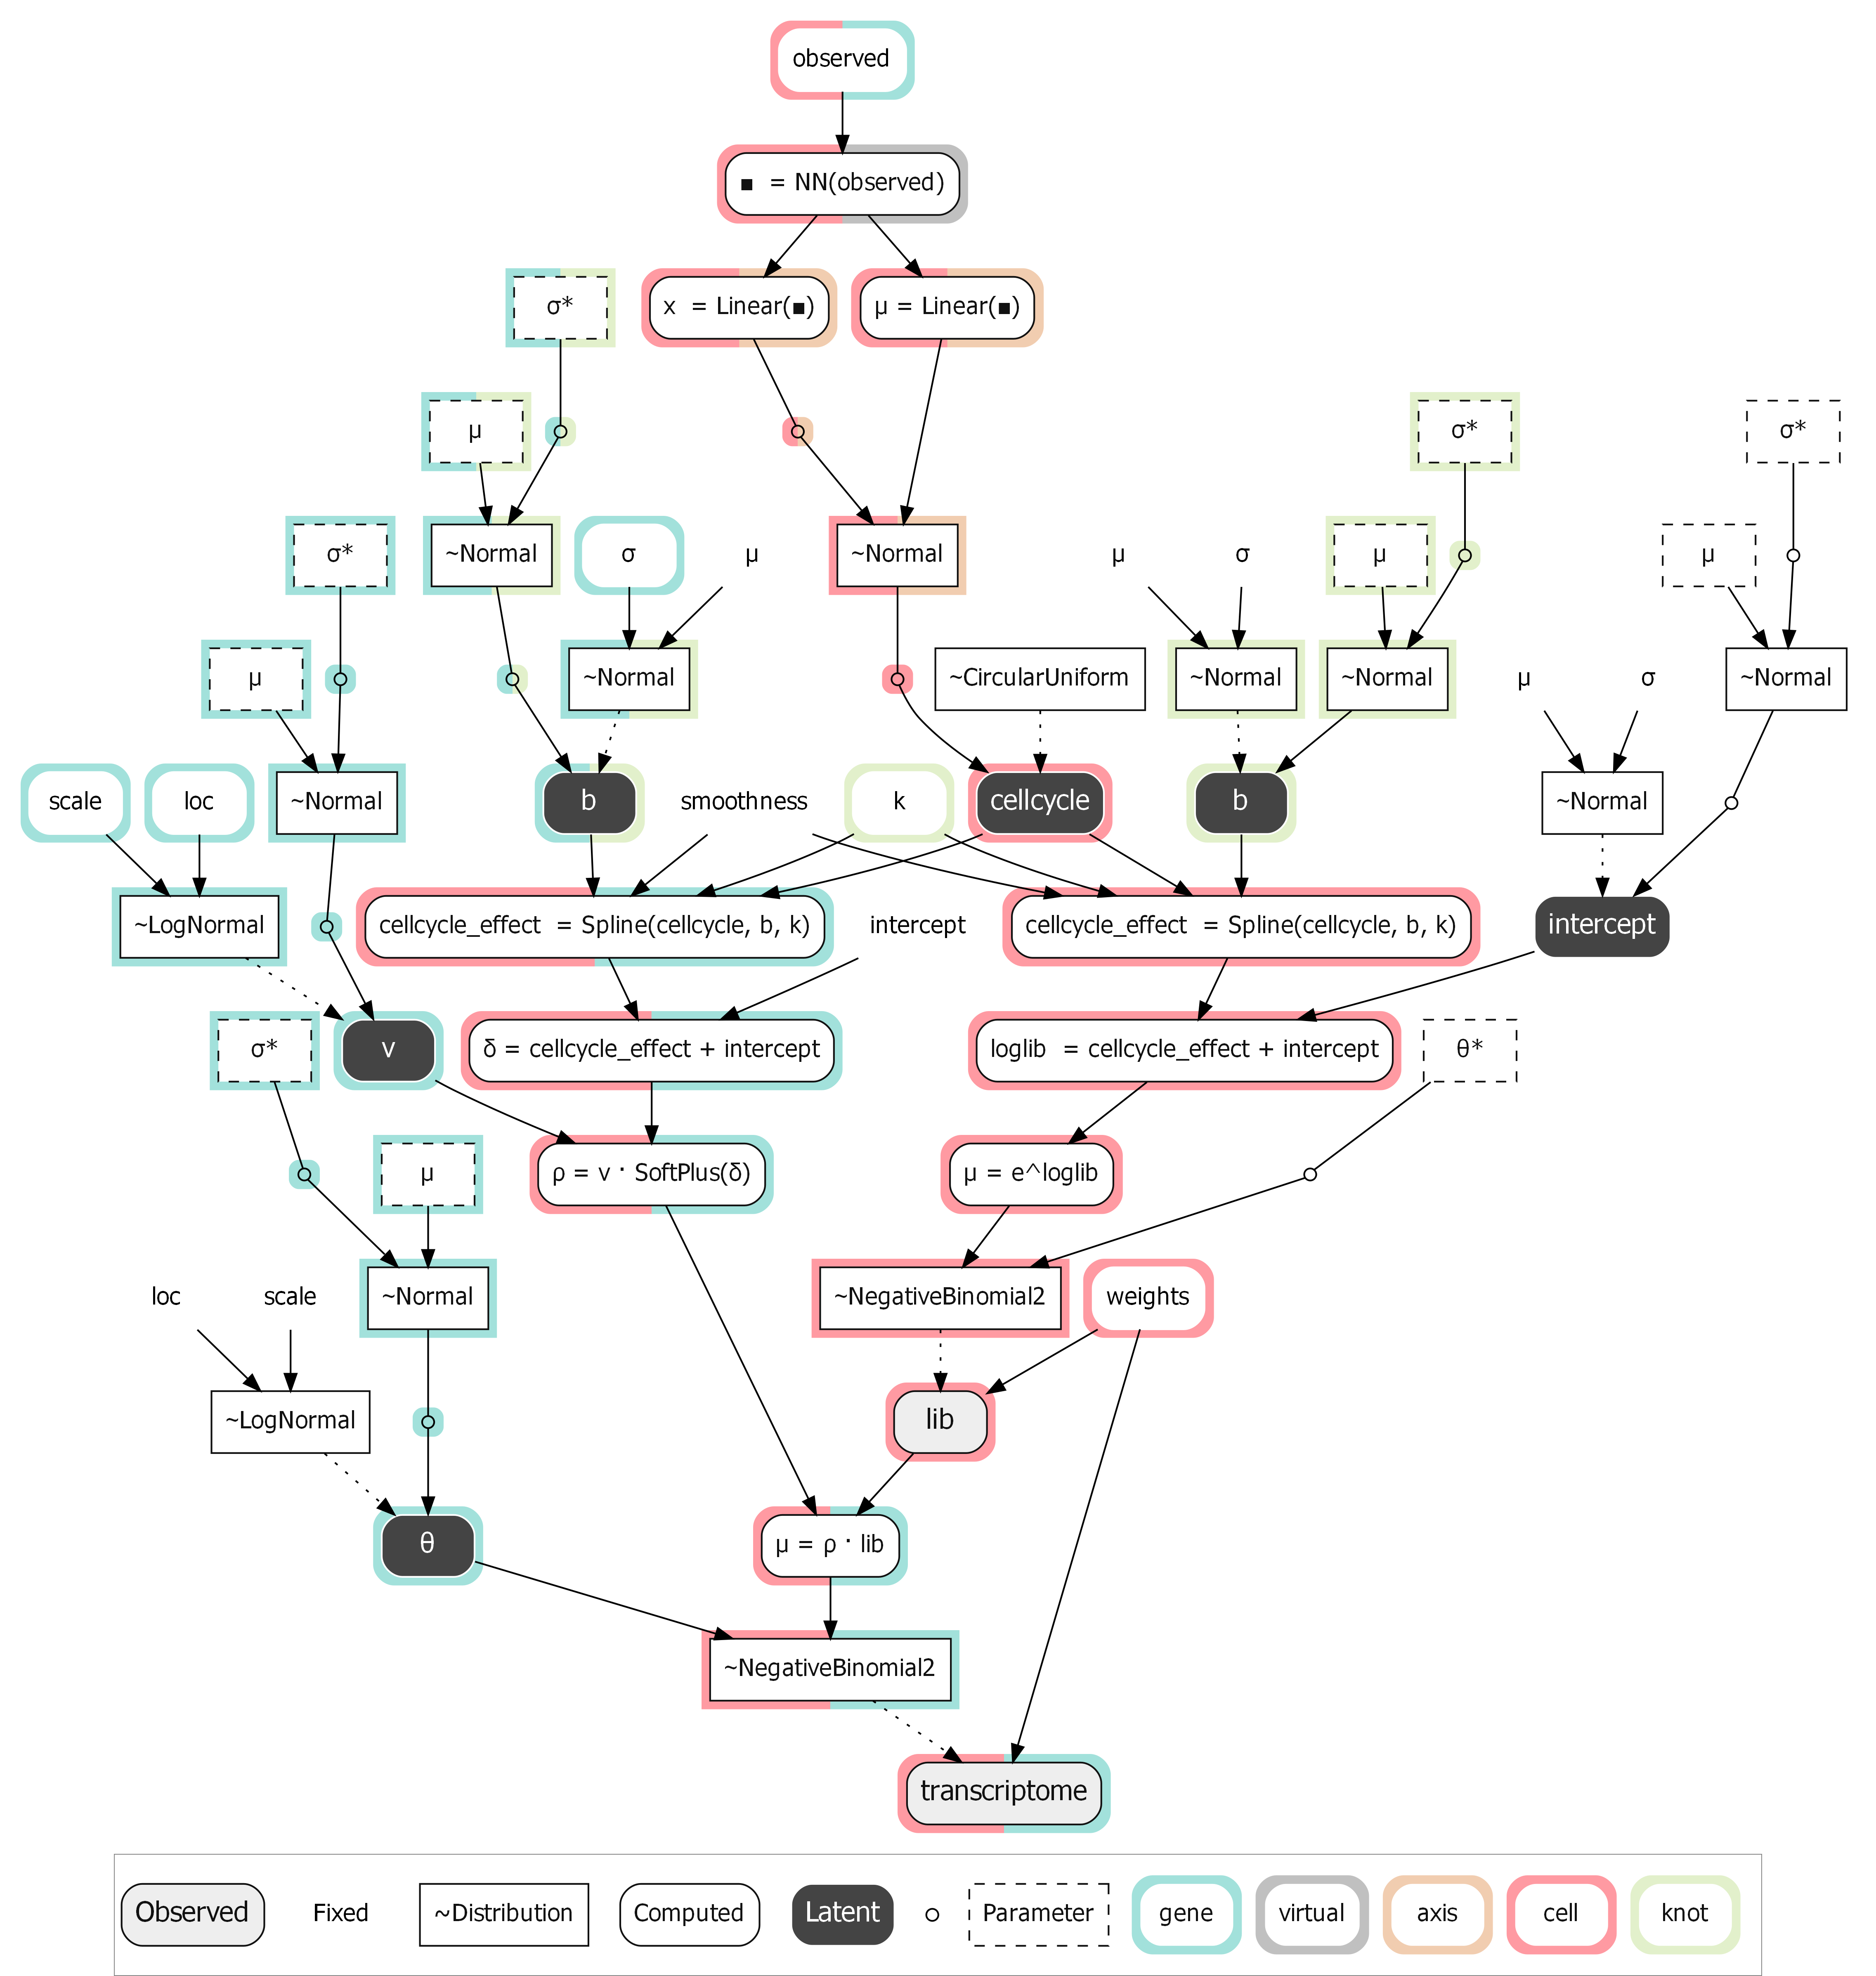

In [20]:
la.interpretation.filter(transcriptome, variational = False, prior = False)
la.interpretation.ComponentGraph(transcriptome).display_graphviz()

In [32]:
transcriptome.to("cuda")

In [33]:
inference = la.infer.svi.SVI(transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.01), device = "cuda")#, subsamplers = {"cell":la.infer.subsampling.Subsampler(500)})
trainer = la.infer.trainer.Trainer(inference)

In [34]:
trace = trainer.train(10000)

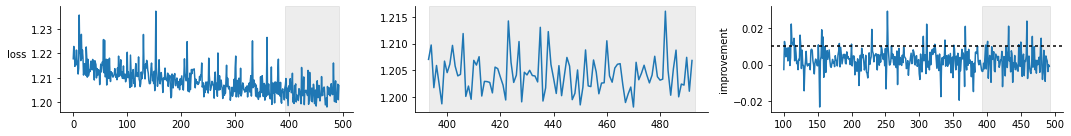

In [35]:
trace.plot();

In [36]:
transcriptome.dist.mu.expression.reset_recursive()

In [37]:
transcriptome.reset_recursive()
transcriptome.to("cpu")

In [38]:
posterior = la.posterior.Observed(transcriptome)
posterior.sample(10)

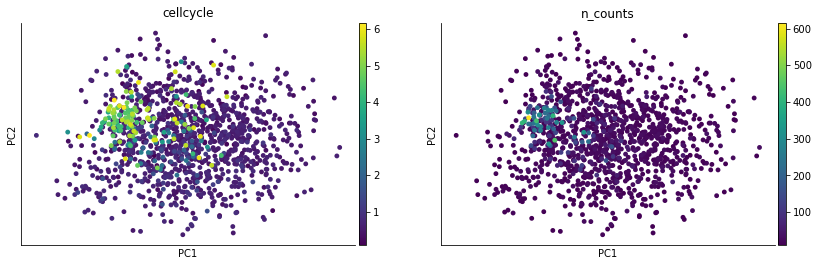

In [39]:
dataset.adata.obs["cellcycle"] = la.domains.circular.mean(posterior.samples[cellcycle], "sample")
sc.pl.pca(dataset.adata, color = ["cellcycle", "n_counts"])

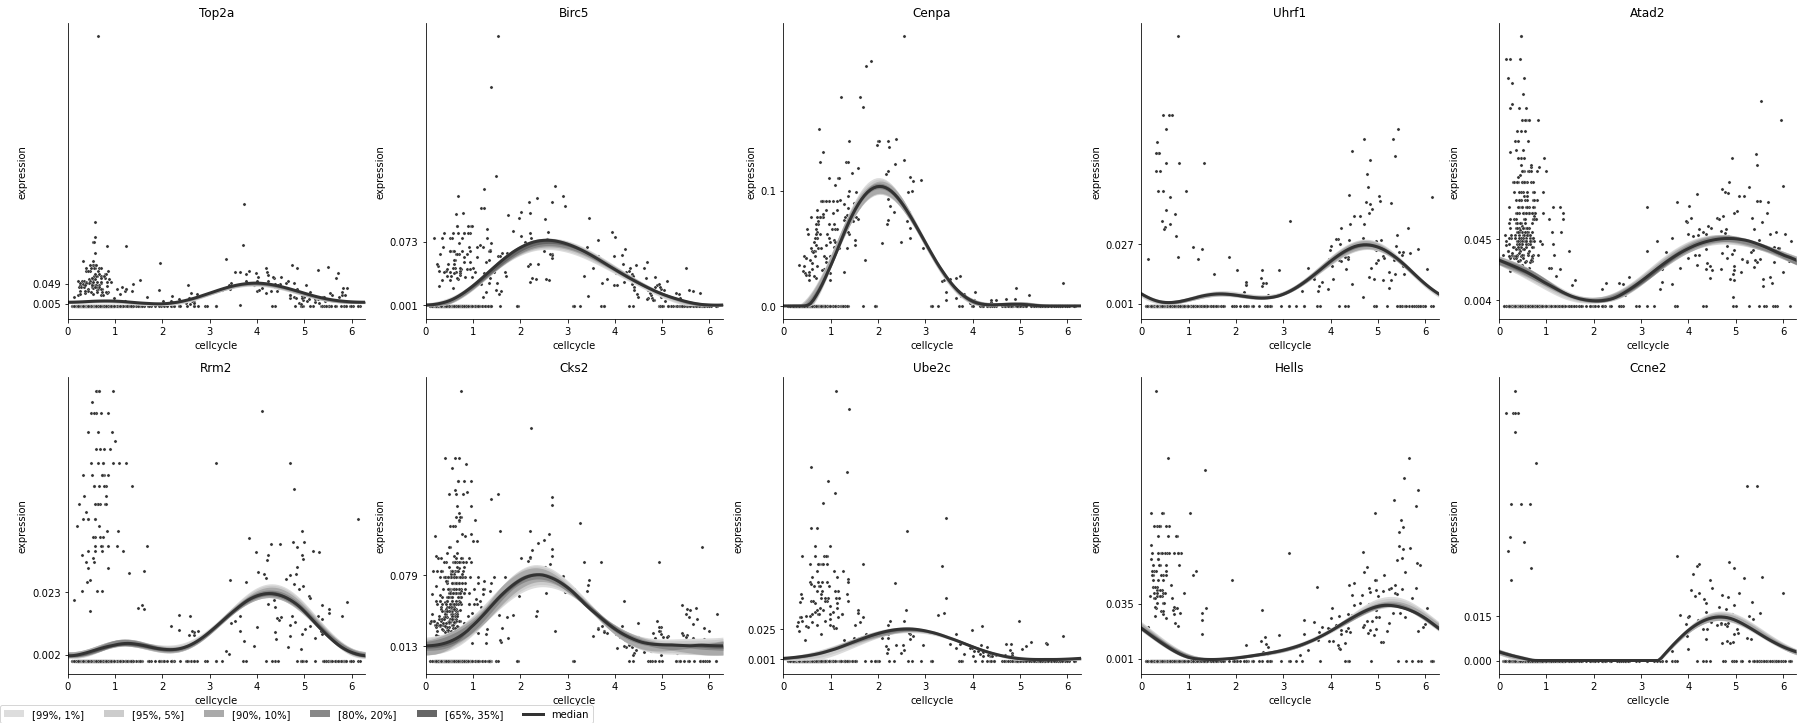

In [40]:
causal = la.posterior.ScalarVectorCausal(cellcycle, transcriptome, observed = posterior)
causal.sample(10)
causal.plot_features(transcriptome.dist.mu.expression);

<AxesSubplot:ylabel='phase'>

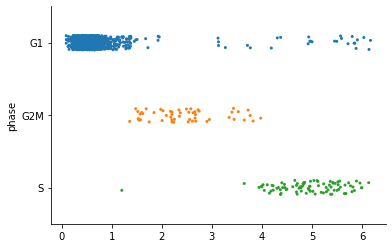

In [41]:
sns.stripplot(x = posterior.samples[cellcycle].mean("sample"), y = dataset_oi.obs["phase"], size = 3)

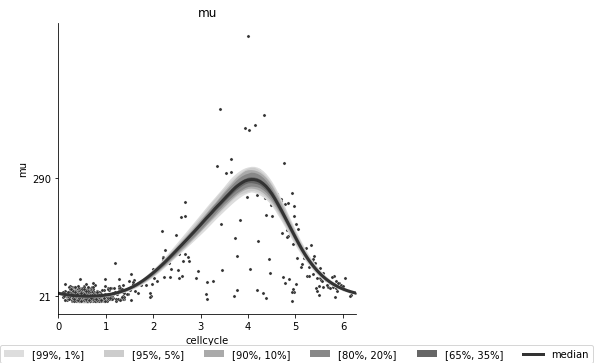

In [42]:
causal = la.posterior.ScalarScalarCausal(cellcycle, transcriptome.dist.mu.library, observed = posterior)
causal.sample(100)
causal.plot();

## On all genes

In [94]:
experiment = lam.Experiment("cellcycle_full")

In [95]:
counts = pd.read_csv(experiment.data_file("counts.csv"), header = None)
var = pd.read_csv(experiment.data_file("var.csv"), index_col = 0)
var.index.name = "gene"
obs = pd.read_csv(experiment.data_file("obs.csv"), index_col = 0)
obs.index.name = "cell"

obs["batch"] = obs["experiment_ix"].astype("category")
obs["viral"] = np.log(obs["vector"] + 1)

counts.index = var.index
counts.columns = obs.index

counts = counts.T
adata = sc.AnnData(counts, obs, var)

sc.pp.filter_cells(adata, min_counts = 100)
sc.pp.filter_genes(adata, min_counts = 100)

dataset2 = lac.dataset.Dataset(lac.dataset.Transcriptome(adata))

In [96]:
sc.pp.normalize_per_cell(dataset2.adata)
if "log1p" not in dataset2.uns: sc.pp.log1p(dataset2.adata)
sc.pp.highly_variable_genes(dataset2.adata)
sc.pp.pca(dataset2.adata)
sc.pp.neighbors(dataset2.adata)
sc.tl.umap(dataset2.adata)

In [97]:
variational = cellcycle.variational.clone()
nn2 = variational.x.loc.x
nn2.x = la.Fixed(counts[list(nn2.x[1].coords)].astype(np.float))

In [98]:
variational.run_recursive()
variational.x.loc = variational.x.loc.to_fixed()
variational.x.scale = variational.x.scale.to_fixed()

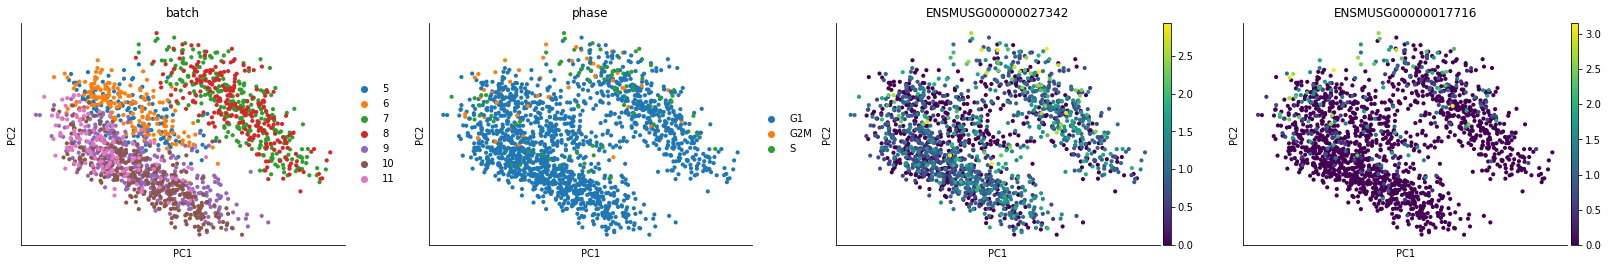

In [160]:
sc.pl.pca(dataset2.adata, color = ["batch", "phase"] + dataset2.feature_id(["Pcna", "Birc5"]))

In [151]:
cellcycle = variational
cellcycle.label = "cellcycle"

In [152]:
dataset_oi = dataset2

In [153]:
weights_value = pd.Series((1/dataset_oi.obs["phase"].value_counts())[dataset_oi.obs["phase"]].values, index = dataset_oi.obs.index)
weights_value = weights_value/weights_value.sum() * len(weights_value)
weights = la.Fixed(weights_value)

In [154]:
transcriptome = lac.transcriptome.Transcriptome(dataset_oi["transcriptome"], weights = weights)

In [155]:
transcriptome.dist.mu.expression.frequency = lac.transcriptome.BatchFrequency(dataset_oi.obs["batch"], transcriptome.dist.mu.expression.frequency)

In [156]:
variational.distribution = la.distributions.CircularUniform()

In [157]:
transcriptome.dist.mu.expression.foldchange.cellcycle_effect = la.links.scalar.Spline(
    cellcycle, 
    output = transcriptome.dist.mu.expression.foldchange, 
    distance = la.links.scalar.spline.circular,
    n_knots = 10,
)

??: loc, scale ↦ Normal [gene (•)]



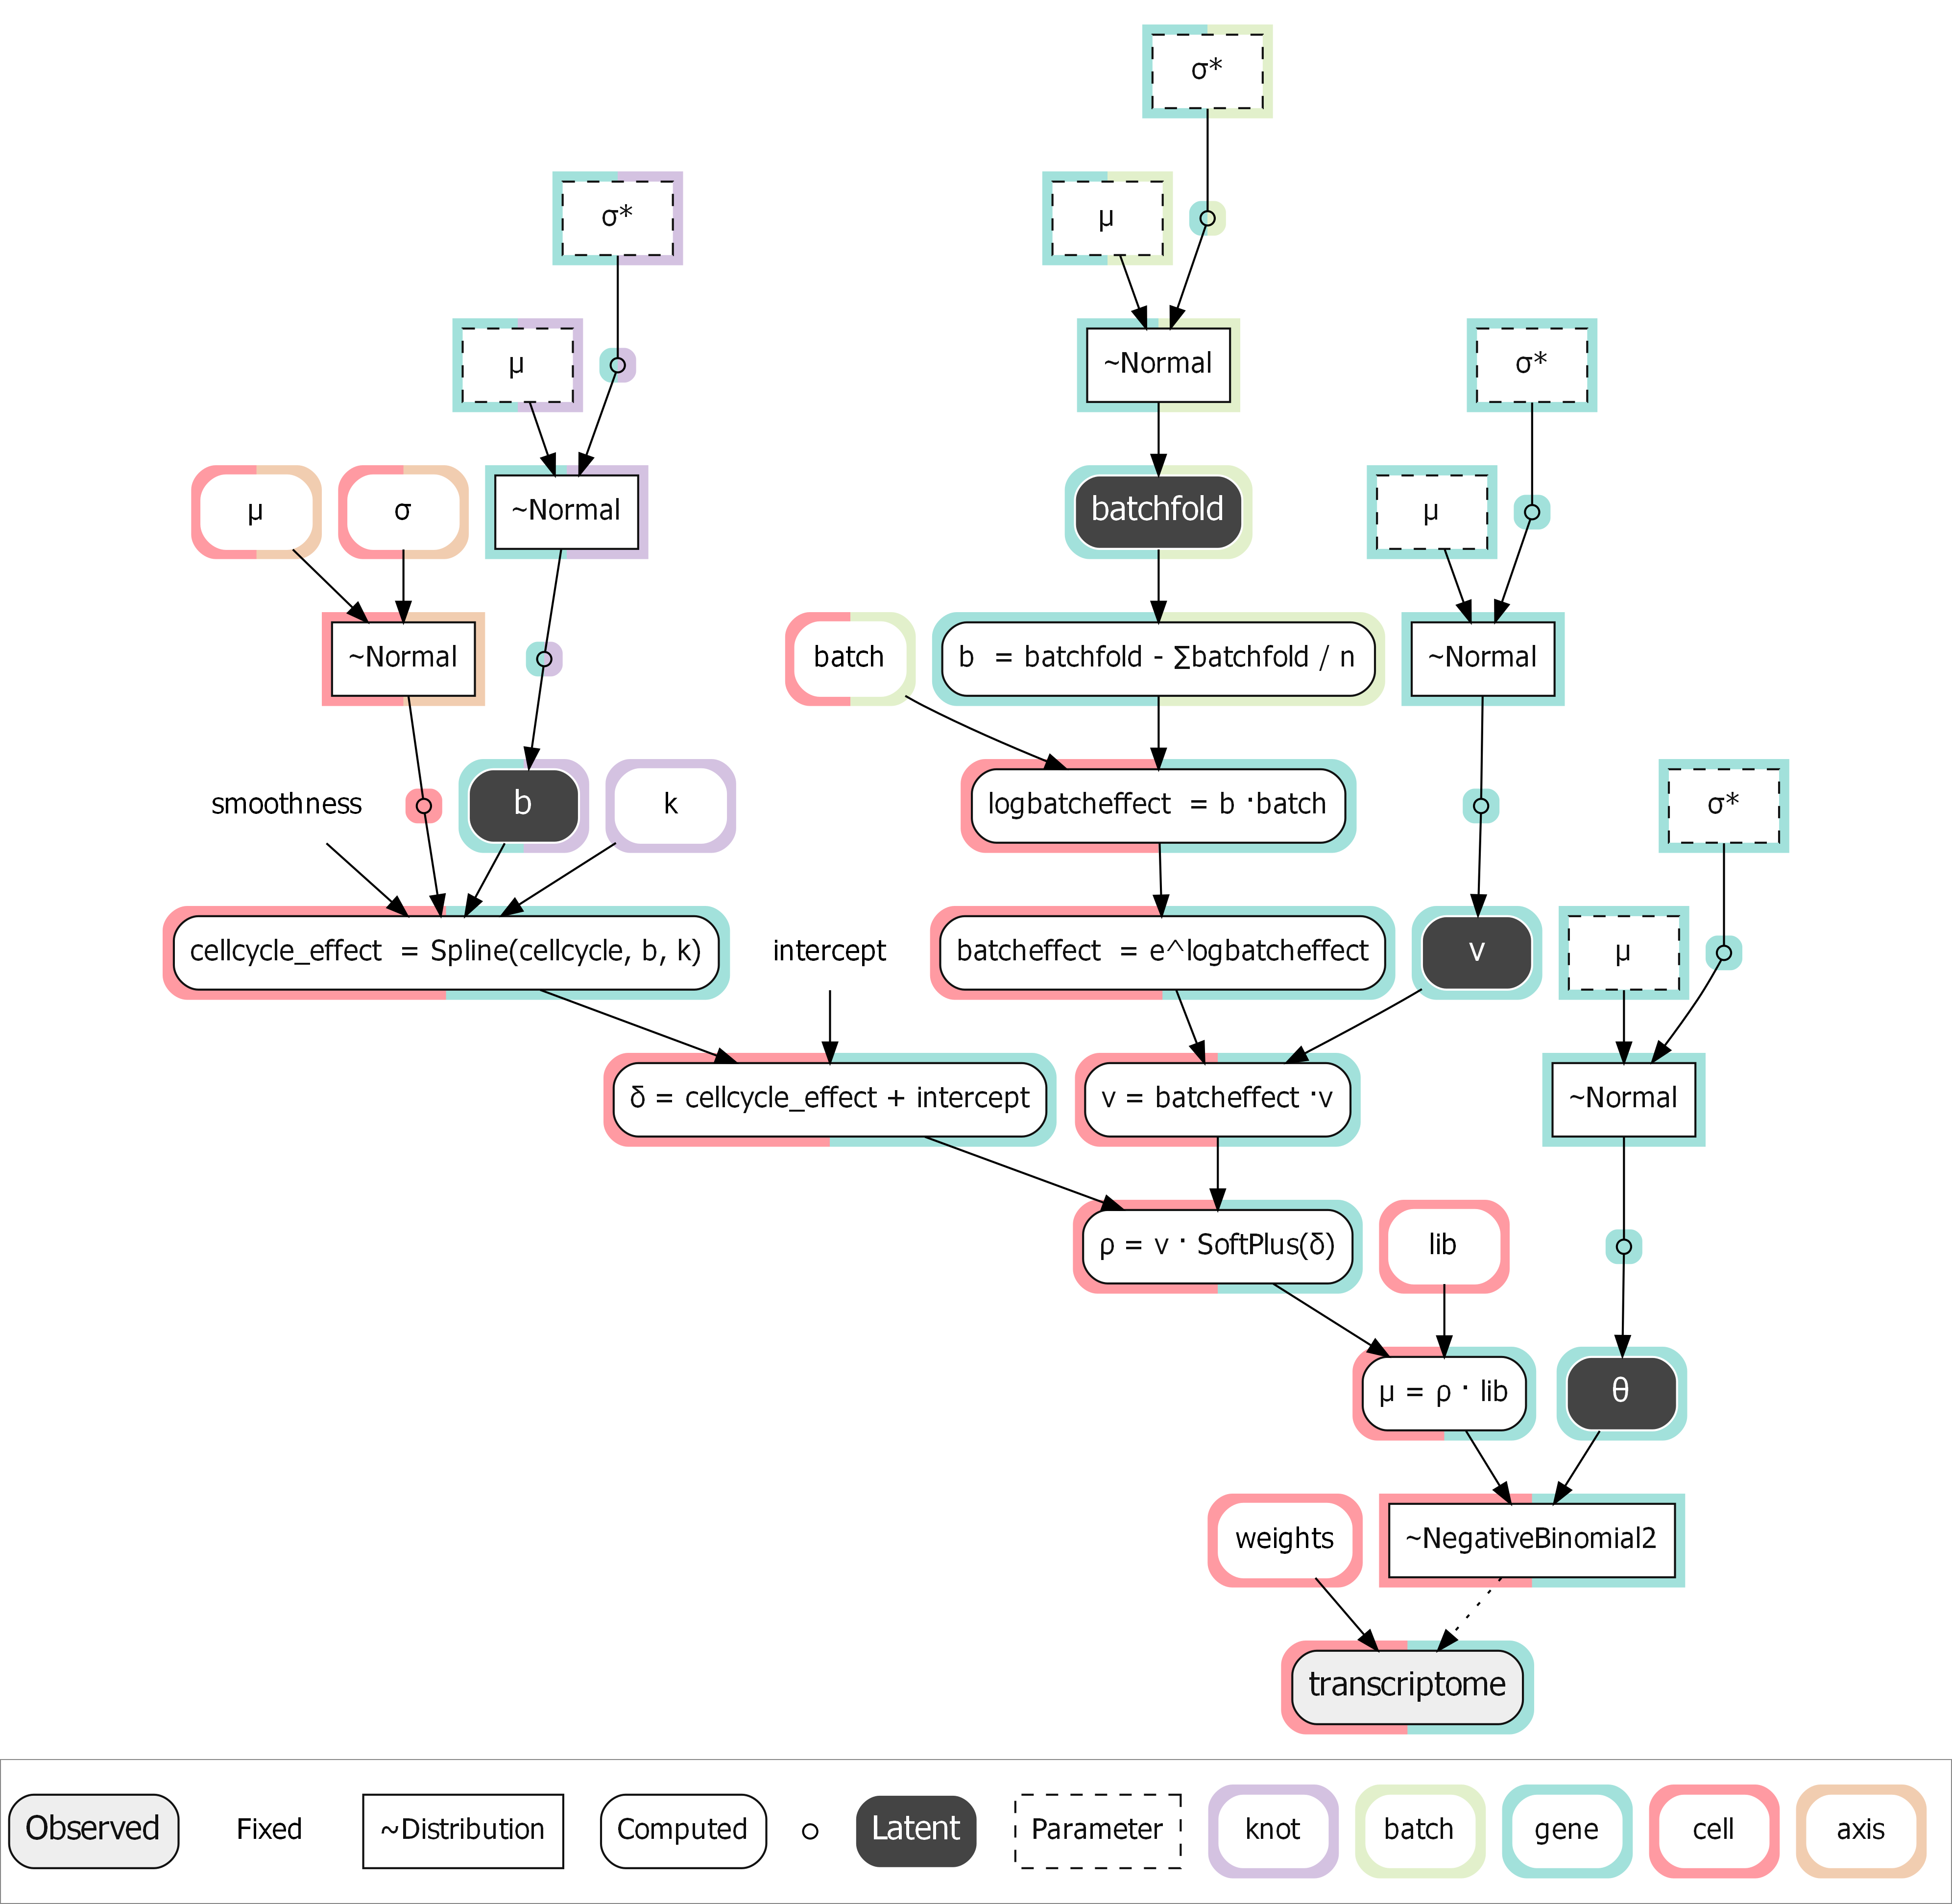

In [159]:
la.interpretation.filter(transcriptome, variational = False)
la.interpretation.ComponentGraph(transcriptome).display_graphviz()

In [126]:
transcriptome.to("cuda")

In [127]:
inference = la.infer.svi.SVI(transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.01), device = "cuda", subsamplers = {"cell":la.infer.subsampling.Subsampler(500)})
trainer = la.infer.trainer.Trainer(inference)

In [128]:
trace = trainer.train(10000)

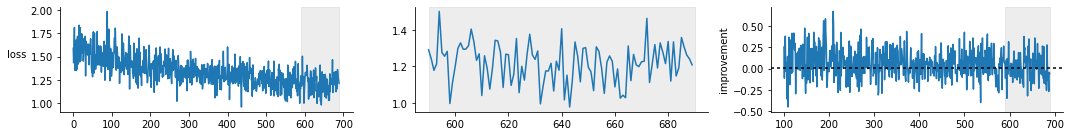

In [129]:
trace.plot();

In [130]:
transcriptome.to("cpu")

In [131]:
posterior = la.posterior.Observed(transcriptome)
posterior.sample(1)

In [132]:
dataset_oi.obs["cellcycle"] = posterior.samples[cellcycle].mean("sample")

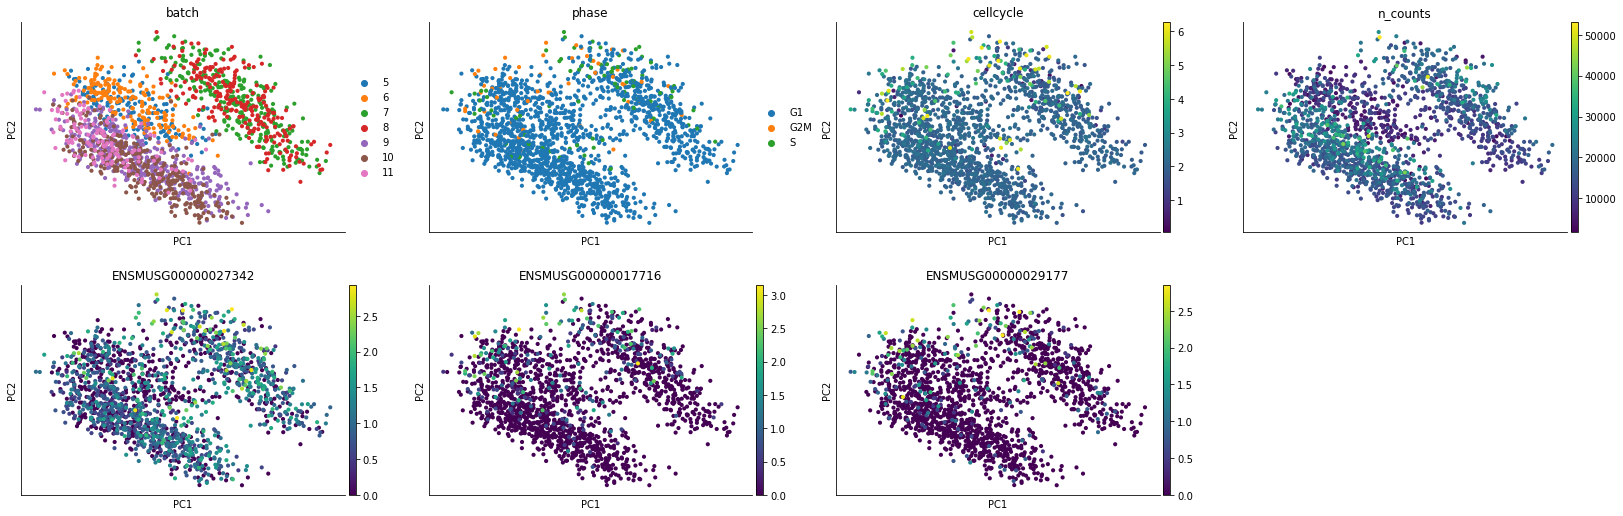

In [141]:
sc.pl.pca(dataset_oi.adata, color = ["batch", "phase", "cellcycle", "n_counts"] + dataset2.feature_id(["Pcna", "Birc5", "Cenpa"]))

In [142]:
causal = la.posterior.ScalarVectorCausal(cellcycle, transcriptome, observed = posterior)
causal.sample(10)

In [149]:
causal.sample_bootstrap(1)

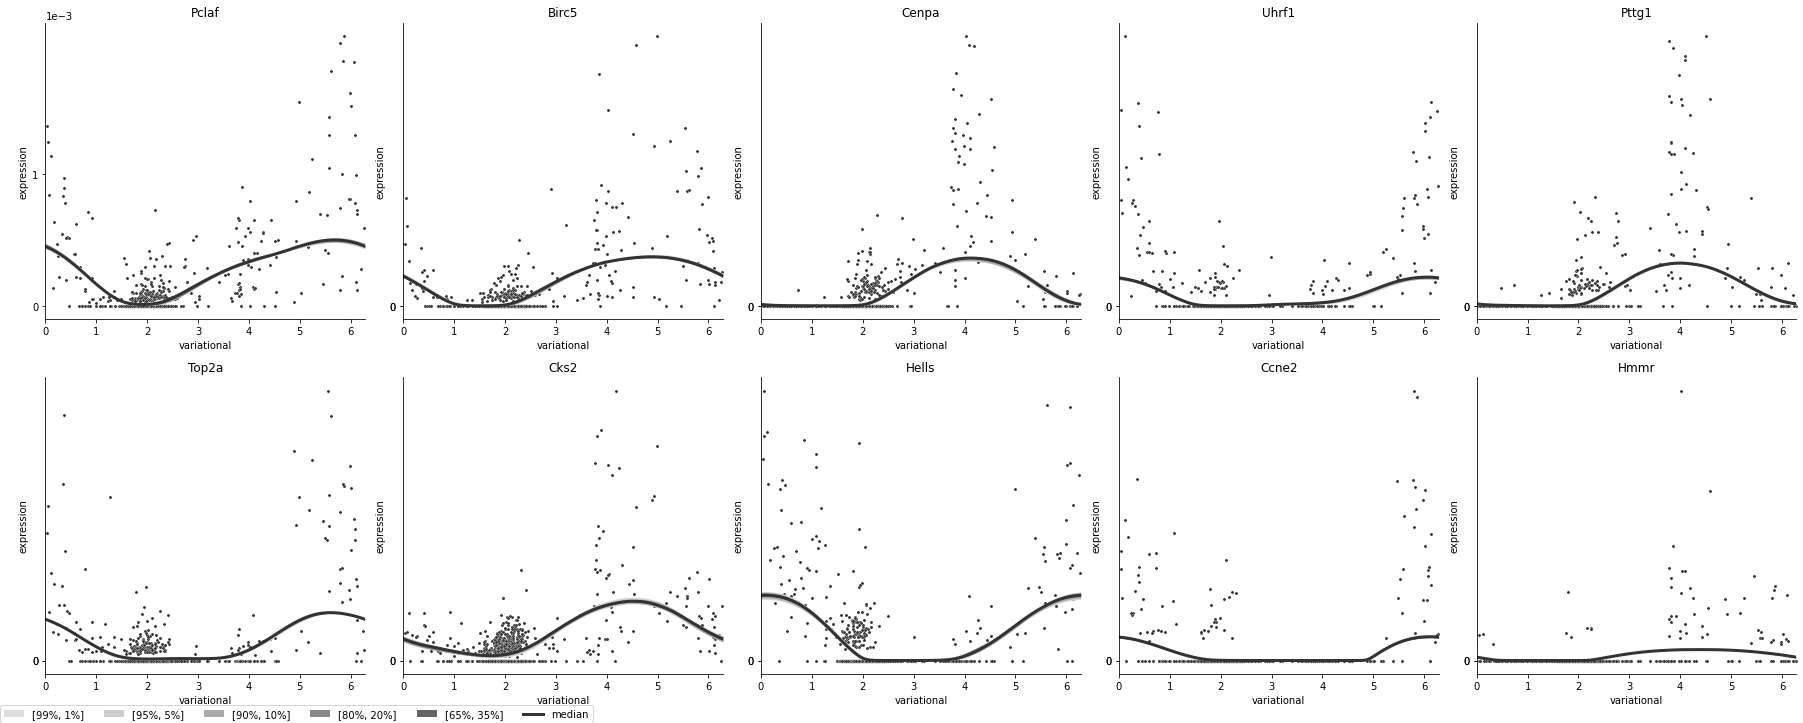

In [150]:
causal.plot_features(transcriptome.dist.mu.expression);

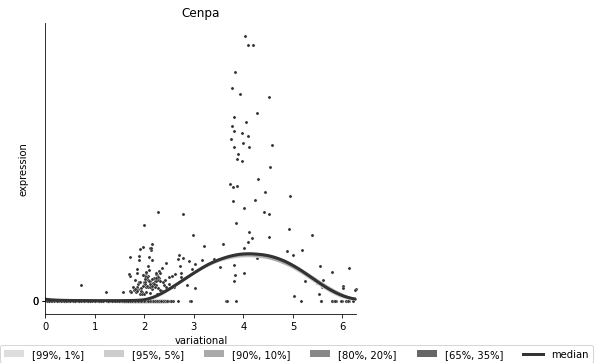

In [147]:
causal.plot_features(transcriptome.dist.mu.expression, dataset.feature_id(["Cenpa"]));

In [ ]:
sns.heatmap()

---------------

In [31]:
transcriptome_posterior = lac.transcriptome.TranscriptomePosterior(model2, "transcriptome")
transcriptome_posterior.sample(1)
transcriptome_posterior.print_summary()

Evidence: 0.7360380419124923
Likelihood: -0.648917134775222


('Evidence: 0.7360380419124923', 'Likelihood: -0.648917134775222')

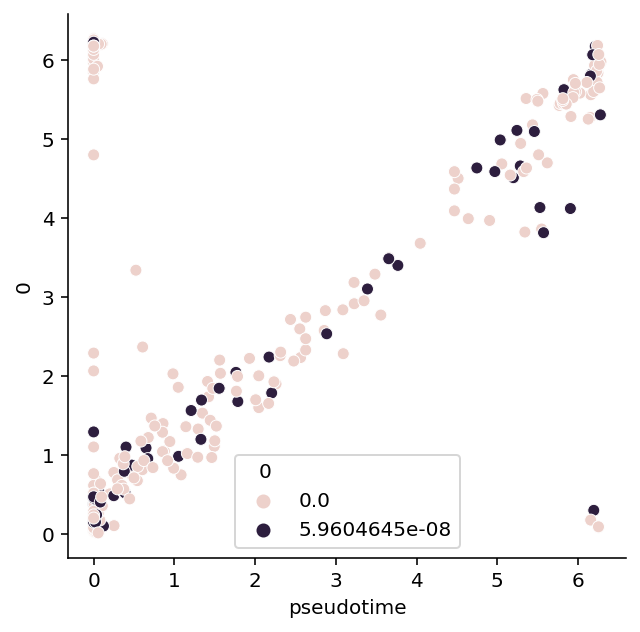

In [32]:
circular_observed = lac.circular.CircularObserved(model, "circular", observed_posterior = transcriptome_posterior)
circular_observed.plot_initialization()

In [38]:
circular_causal = lac.circular.CircularCausal(model2, "circular", "transcriptome", observed_posterior = transcriptome_posterior)
circular_causal.sample(100)
circular_causal.sample_shuffled(1)

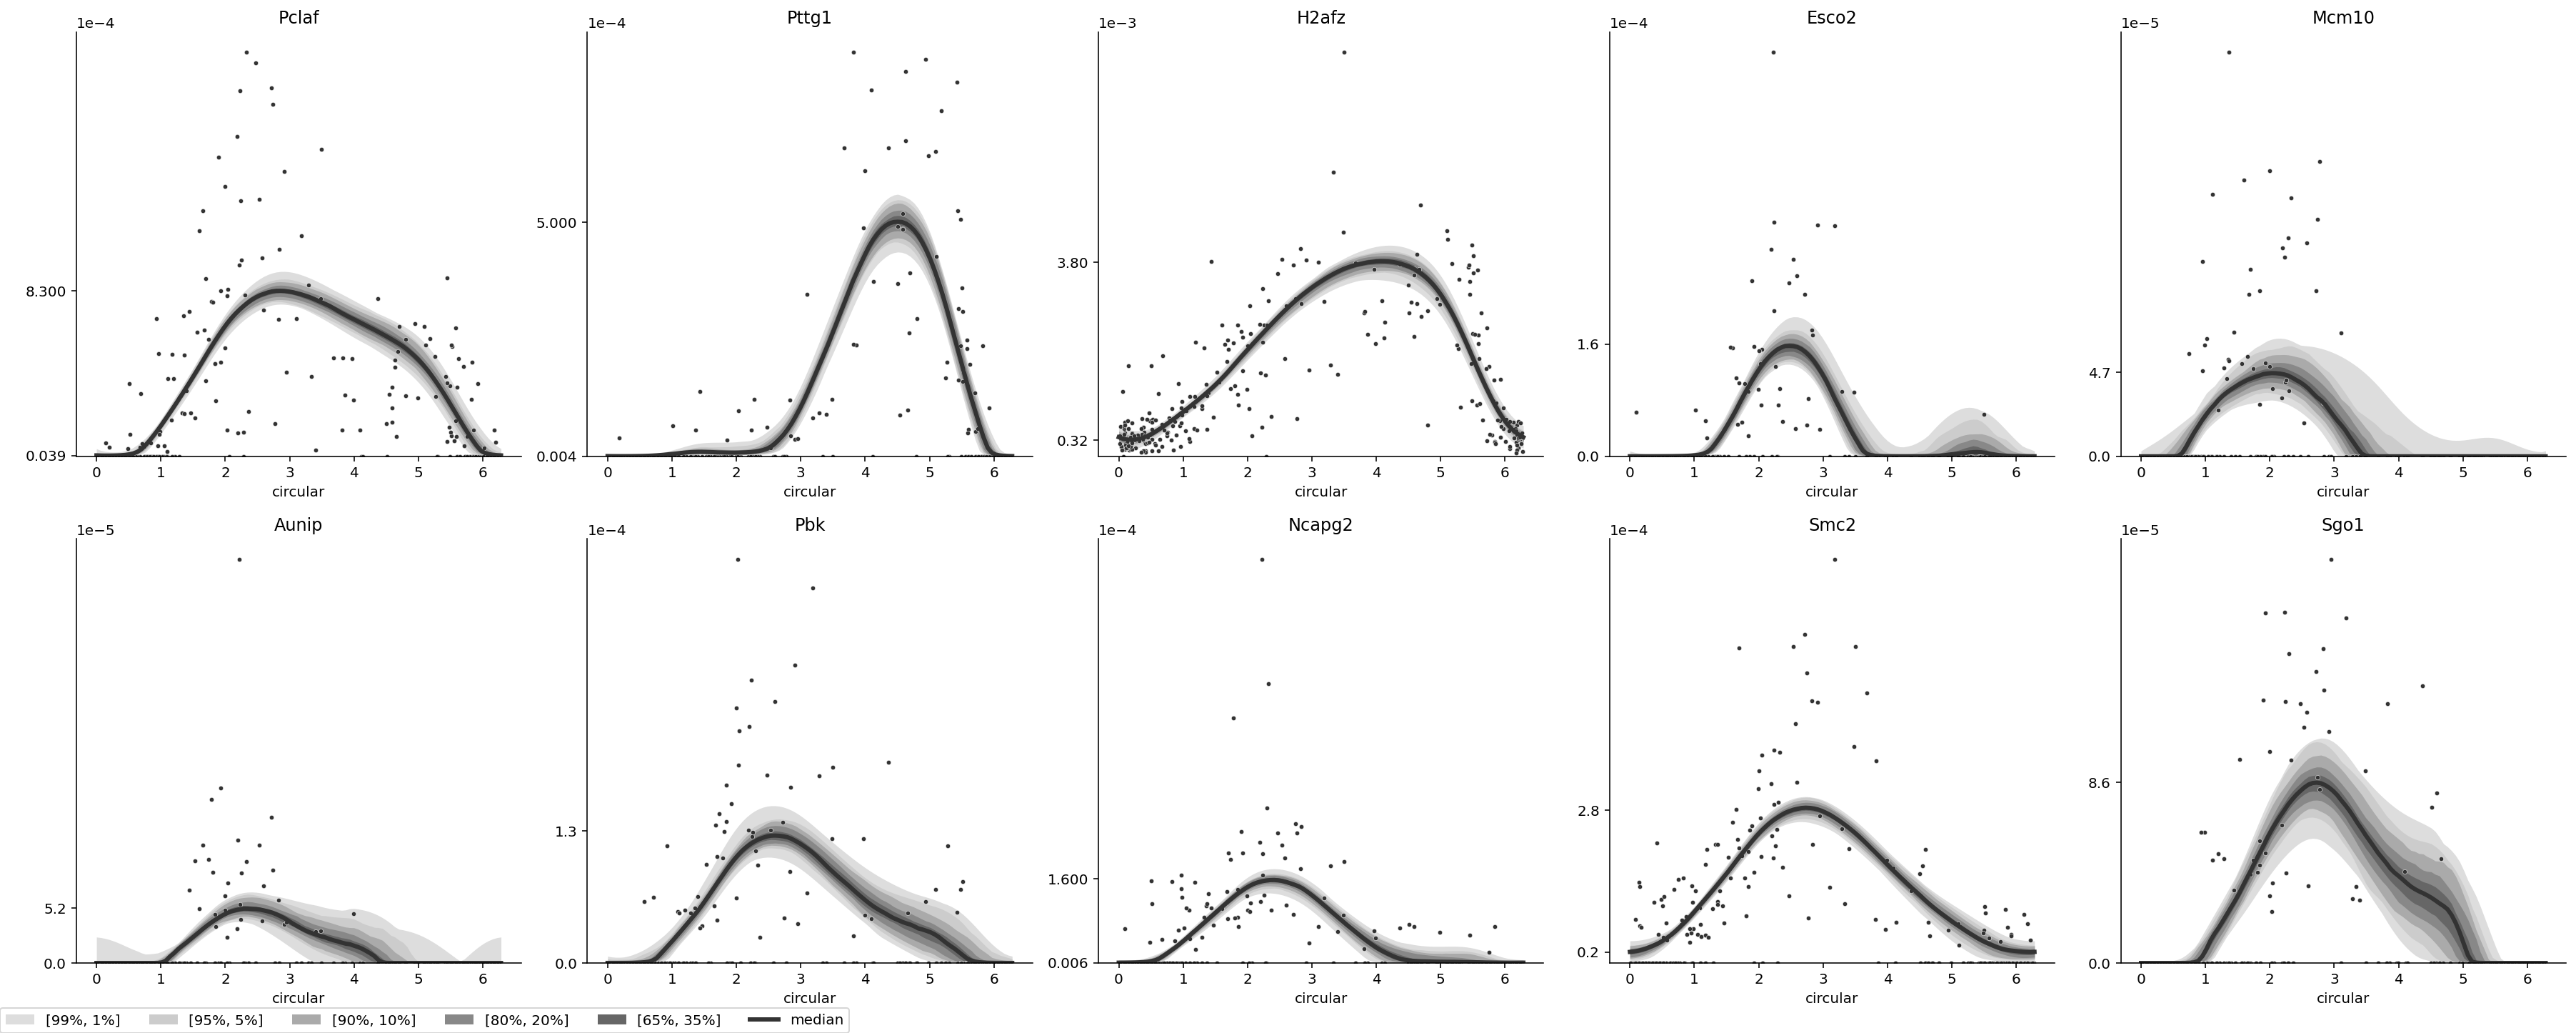

In [45]:
circular_causal.plot_features(circular_causal.scores[~circular_causal.scores["gene"].isin(dataset.var.index)].sort_values("lr", ascending = False)["gene"][:10]);